In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
from tqdm import tqdm

from datetime import datetime
import glob
import math
import matplotlib.pyplot as plt


from PIL import Image
import random as python_random
#import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, GlobalAveragePooling2D, Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.applications.resnet import ResNet50, preprocess_input

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

2022-12-04 23:55:55.880945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:55:55.979754: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-04 23:55:56.546863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jupyter-anthony/miniconda3/envs/cxr_work/lib/python3.9/site-packages/cv2/../../l

# Train logs

In [8]:
logs = pd.read_csv('saved_models/cxr_densenet_All_race_20221204-154429.log')
logs

,epoch,PR-AUC,ROC-AUC,accuracy,loss,lr,val_PR-AUC,val_ROC-AUC,val_accuracy,val_loss
0,0,0.762120,0.875137,0.726942,0.684777,0.00100,0.842154,0.913880,0.789381,0.606306
1,1,0.834791,0.908427,0.769308,0.578497,0.00100,0.553212,0.763240,0.546180,0.923028
2,2,0.881580,0.932812,0.809078,0.497027,0.00100,0.936648,0.963939,0.874453,0.371580
3,3,0.912088,0.949994,0.839030,0.428281,0.00100,0.701155,0.837426,0.682588,0.803229
4,4,0.930544,0.960552,0.858239,0.379329,0.00100,0.958430,0.976194,0.896779,0.290808
5,5,0.941613,0.967099,0.872101,0.344542,0.00100,0.952637,0.973393,0.891219,0.307145
6,6,0.949403,0.971645,0.882265,0.318613,0.00100,0.926719,0.959927,0.851435,0.380605
7,7,0.967146,0.981671,0.909177,0.253193,0.00010,0.978209,0.987885,0.931148,0.201570
8,8,0.971099,0.983956,0.914428,0.235773,0.00010,0.976230,0.986861,0.926423,0.210626
9,9,0.973084,0.985116,0.918695,0.226121,0.00010,0.980492,0.989023,0.937399,0.187305


### loss vs epochs

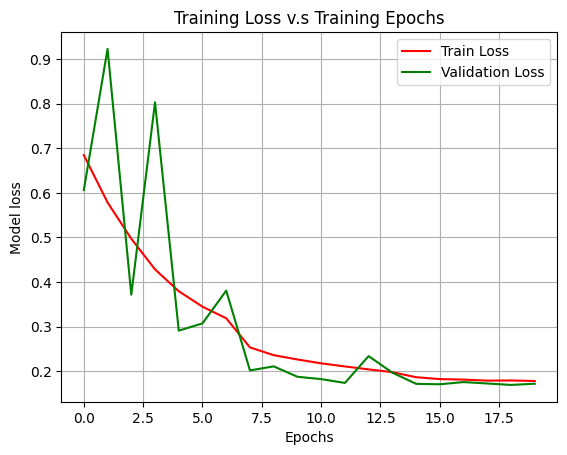

In [9]:
N_EPOCHS = logs.epoch.max() + 1
# Plot model loss vs epochs
#plt.title('Model loss vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Model loss")
plt.title('Training Loss v.s Training Epochs')
plt.grid()
plt.plot(range(N_EPOCHS), logs['loss'], '-', color="r")
plt.plot(range(N_EPOCHS), logs['val_loss'], '-', color="g")
plt.legend(['Train Loss', 'Validation Loss', 'Test'])
plt.show()

### epochs vs. model accuracy

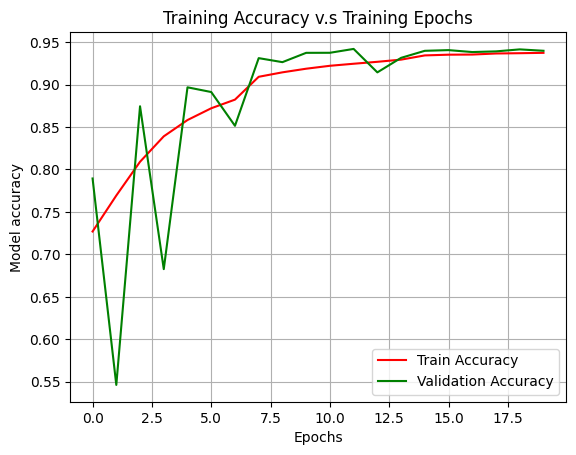

: 

In [10]:
# Make a plot of epochs vs. model accuracy
#plt.title('Epochs vs. Model Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Model accuracy")
plt.title('Training Accuracy v.s Training Epochs')
plt.grid()
plt.plot(range(N_EPOCHS), logs['accuracy'], '-', color="r")
plt.plot(range(N_EPOCHS), logs['val_accuracy'], '-', color="g")
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Test'])
plt.show()

# Test prediction

In [2]:
from keras.applications.resnet import ResNet50, preprocess_input
# Recreate the exact same model, including its weights and the optimizer
model_path = 'saved_models/densenet_All_race_detection_LR-0.001_20221204-154429_epoch_019_val_loss_0.16900.h5'
#'saved_models/ResNet50_All_race_detection_LR-0.001_20221204-034954_epoch_005_val_loss_0.49068.h5'
try:
  # Specify an invalid GPU device
  with tf.device('/GPU:1'):
    disease = 'All'
    task = 'race' # race
    num_class = 2 if task == 'survive' else 3
    model_name = 'densenet'
    HEIGHT = 256
    WIDTH = 256

    def define_densenet_model(n_classes=1, input_shape=(224,224,3)):
        base_model = tf.keras.applications.densenet.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
        x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model.output)
        x = Flatten()(x)
        x = Dense(1024, activation='relu', name='dense_post_pool')(x)
        x = Dropout(0.2)(x)
        output = Dense(n_classes, activation='softmax', name='predictions')(x)
        model = Model(inputs=base_model.input, outputs=output)
        return model

    if model_name == 'densenet':
        HEIGHT = 224
        WIDTH = 224
        model = define_densenet_model(num_class) #define_densenet_model()
        preprocess_input = tf.keras.applications.densenet.preprocess_input
    elif model_name == 'resnet50':
        input_a = Input(shape=(HEIGHT, WIDTH, 3))
        base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', 
                            input_tensor=input_a,
                            include_top=False, 
                            input_shape=(HEIGHT, WIDTH, 3)
                            )

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(num_class, name='dense_logits')(x)
        output = Activation('softmax', dtype='float32', name='predictions')(x)
        model = Model(inputs=[input_a], outputs=[output])
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        for layer in base_model.layers: # keep base_model aside from training
            layer.trainable = False
    # input_a = Input(shape=(HEIGHT, WIDTH, 3))
    # base_model = ResNet50(weights='imagenet', 
    #                     input_tensor=input_a,
    #                     include_top=False, 
    #                     input_shape=(HEIGHT, WIDTH, 3)
    #                     )

    # x = GlobalAveragePooling2D()(base_model.output)
    # x = Dense(num_class, name='dense_logits')(x)
    # output = Activation('softmax', dtype='float32', name='predictions')(x)
    # model = Model(inputs=[input_a], outputs=[output])

    model.load_weights(model_path)

    # test_size = 57702
    # print('Test size: ', test_size)

    # Show the model architecture
    #print(model.summary())
    
    data_dir = f'data/{disease}/images/{task}'
    test_dir = f'{data_dir}/test'
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_batch_size = 64

    dir_to_save = f'data/{disease}/images/{task}'

    if task == 'race':
        class_names = ['ASIAN', 'BLACK', 'WHITE']
    elif task == 'survive':
        class_names = ['DIE', 'SURVIVE'] # order must match folder

    datasets = ['test']
    y = []
    for ds in datasets:
        for cls in class_names:
            DIR = f'{dir_to_save}/{ds}/{cls}'
            lst = os.listdir(DIR)
            n_files = len(lst)
            print(ds,cls,n_files)
            y.extend([cls] * n_files)
            
    test_size = len(y)
    
    test_batches = test_gen.flow_from_directory(
                                    directory= test_dir,
                                    classes = None, # means automatically infer the label from subdir
                                    class_mode = 'categorical', # white, black, asian
                                    target_size=(HEIGHT, WIDTH),
                                    shuffle=False,
                                    # seed=seed, 
                                    batch_size= test_batch_size
    )
    multilabel_predict_test = model.predict(test_batches, 
                    #max_queue_size=10, 
                    verbose=1, 
                    steps=math.ceil(test_size/test_batch_size), 
                    #workers=32
                    )
    
except RuntimeError as e:
  print(e)


2022-12-04 23:57:04.444518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:57:05.944844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 195 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-12-04 23:57:05.945802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22286 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


test ASIAN 1459
test BLACK 7148
test WHITE 44519
Found 53126 images belonging to 3 classes.


2022-12-04 23:57:11.233483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  3/831 [..............................] - ETA: 56s  

2022-12-04 23:57:13.057827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


831/831 [==============================] - 107s 124ms/step


In [3]:
input_prediction = multilabel_predict_test
#input_df = test_df
input_prediction_df = pd.DataFrame(input_prediction)
input_prediction_df.columns = input_prediction_df.columns.map(str)
var_date = datetime.now().strftime("%Y%m%d-%H%M%S")
input_prediction_df.to_csv(f'saved_models/test_{model_name}_{disease}_{task}_{var_date}.csv', index = False)
print('CSV saved successfully')

CSV saved successfully


In [4]:
input_prediction_df

,0,1,2
0,0.968360,0.021740,0.009900
1,0.139116,0.254376,0.606508
2,0.987625,0.000568,0.011807
3,0.239765,0.320012,0.440223
4,0.881682,0.020241,0.098077
...,...,...,...
53121,0.000364,0.000129,0.999507
53122,0.011060,0.110066,0.878875
53123,0.079175,0.003199,0.917626
53124,0.017291,0.003315,0.979394


### Get Y (ground_truth) by counting test images wrt each class

In [7]:
import os
disease = 'All'
task = 'race'
dir_to_save = f'data/{disease}/images/{task}'

if task == 'race':
    class_names = ['ASIAN', 'BLACK', 'WHITE']
elif task == 'survive':
    class_names = ['DIE', 'SURVIVE'] # order must match folder

datasets = ['train']#['val', 'test']
y = []
for ds in datasets:
    for cls in class_names:
        DIR = f'{dir_to_save}/{ds}/{cls}'
        lst = os.listdir(DIR)
        n_files = len(lst)
        print(ds,cls,n_files)
        y.extend([cls] * n_files)



train ASIAN 4380
train BLACK 25018
train WHITE 74199


In [15]:
from sklearn.utils import class_weight
y_train = y 
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = np.array(y_train))) 
                    )

In [16]:
class_weights

{'ASIAN': 7.884094368340944,
 'BLACK': 1.3802995176806032,
 'WHITE': 0.4654016002012606}

In [13]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = np.array(y_train))

In [6]:
3574 / (1459 + 3574 + 29679)

0.10296151186909426

In [24]:
class_names

['DIE', 'SURVIVE']

## Report test metrics

In [43]:
input_prediction_df = pd.read_csv(f'saved_models/test_{disease}_{task}_{var_date}.csv')
input_prediction_df

,0,1,2
0,0.137005,0.003578,0.859417
1,0.012061,0.019358,0.968580
2,0.207212,0.559160,0.233629
3,0.148230,0.311477,0.540293
4,0.106946,0.139234,0.753819
...,...,...,...
53121,0.001276,0.003582,0.995142
53122,0.029596,0.125460,0.844943
53123,0.008516,0.022306,0.969178
53124,0.005682,0.039609,0.954709


In [6]:
def get_AUC(input_prediction_df, ground_truth, classes):

    auc_array = []
    for i, pathology in enumerate(classes):
        truth = (ground_truth.str.contains(pathology)).apply(int)
        input_prediction_val = input_prediction_df[str(i)]
        pred = input_prediction_val
        AUC = roc_auc_score(truth, pred)
        #true_logits.insert(i, i, truth, True)
        auc_array.append(AUC)
        
    progress_df = pd.DataFrame({'Study':classes, 'AUC':auc_array})
    print(progress_df)

def model_summary(y, test_batches, input_prediction_df, class_names):
    ground_truth = pd.Series(y)
    y_truth = test_batches.classes #ground_truth.replace({'ASIAN': 0, 'BLACK': 1, 'WHITE': 2})
    assert len(y) == len(y_truth)
    get_AUC(input_prediction_df, ground_truth, class_names)
    result = input_prediction_df.to_numpy()
    labels = np.argmax(result, axis=1)
    target_names = class_names #['Asian', 'Black', 'White']

    print ('Classwise ROC AUC \n')
    for p in list(set(labels)):
        fpr, tpr, thresholds = roc_curve(y_truth, result[:,p], pos_label = p)
        auroc = round(auc(fpr, tpr), 2)
        print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(target_names[p], auroc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    #     filename = title + '.svg'
    #     plt.savefig(filename)
    plt.show()

    print(classification_report(y_truth, labels, target_names=target_names))
    class_matrix = confusion_matrix(y_truth, labels)

    sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')

   Study       AUC
0  ASIAN  0.962230
1  BLACK  0.976409
2  WHITE  0.970016
Classwise ROC AUC 

Class - ASIAN ROC-AUC- 0.96
Class - BLACK ROC-AUC- 0.98
Class - WHITE ROC-AUC- 0.97


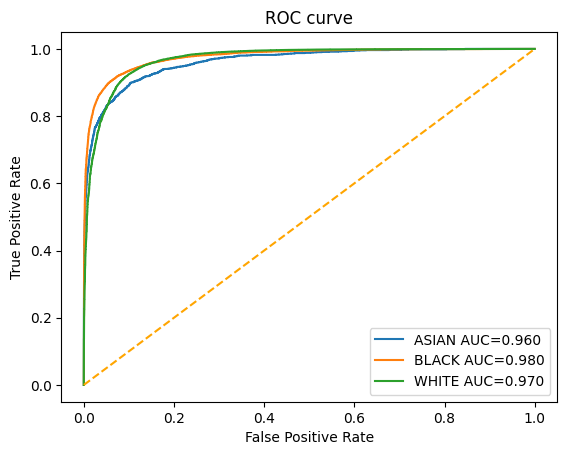

              precision    recall  f1-score   support

       ASIAN       0.64      0.65      0.65      1459
       BLACK       0.85      0.82      0.84      7148
       WHITE       0.97      0.97      0.97     44519

    accuracy                           0.94     53126
   macro avg       0.82      0.82      0.82     53126
weighted avg       0.94      0.94      0.94     53126



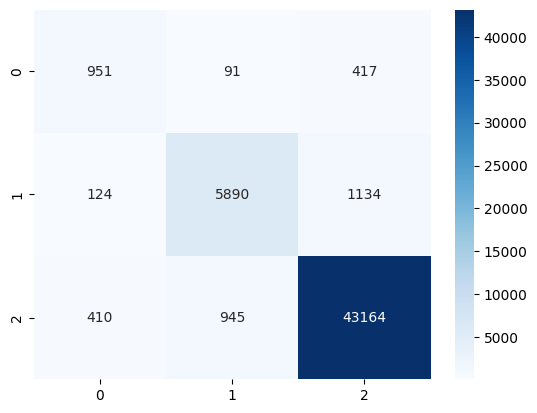

In [7]:

input_prediction_df = pd.read_csv(f'saved_models/test_densenet_All_race_20221204-235957.csv')
model_summary(y, test_batches, input_prediction_df, class_names)

   Study       AUC
0  ASIAN  0.847946
1  BLACK  0.827674
2  WHITE  0.816484
Classwise ROC AUC 

Class - ASIAN ROC-AUC- 0.85
Class - BLACK ROC-AUC- 0.83
Class - WHITE ROC-AUC- 0.82


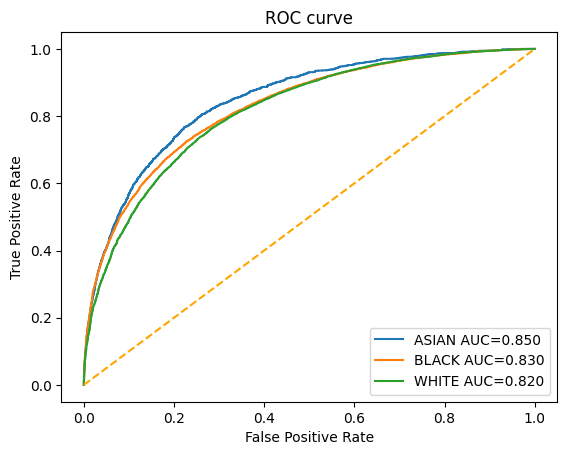

              precision    recall  f1-score   support

       ASIAN       0.10      0.71      0.17      1459
       BLACK       0.51      0.48      0.49      7148
       WHITE       0.93      0.75      0.83     44519

    accuracy                           0.72     53126
   macro avg       0.51      0.65      0.50     53126
weighted avg       0.85      0.72      0.77     53126



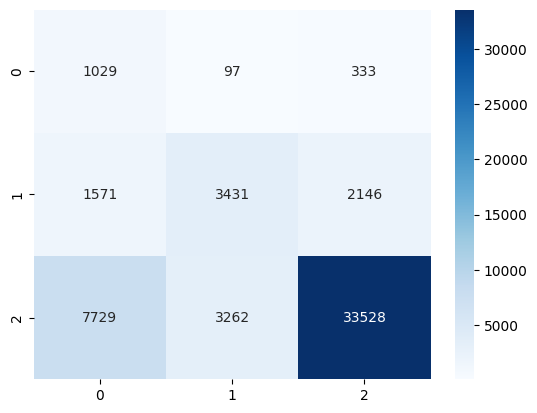

In [33]:

input_prediction_df = pd.read_csv(f'saved_models/test_All_race_20221204-142301.csv')
model_summary(y, test_batches, input_prediction_df, class_names)

   Study       AUC
0  ASIAN  0.837748
1  BLACK  0.840487
2  WHITE  0.828056
Classwise ROC AUC 

Class - ASIAN ROC-AUC- 0.84
Class - BLACK ROC-AUC- 0.84
Class - WHITE ROC-AUC- 0.83


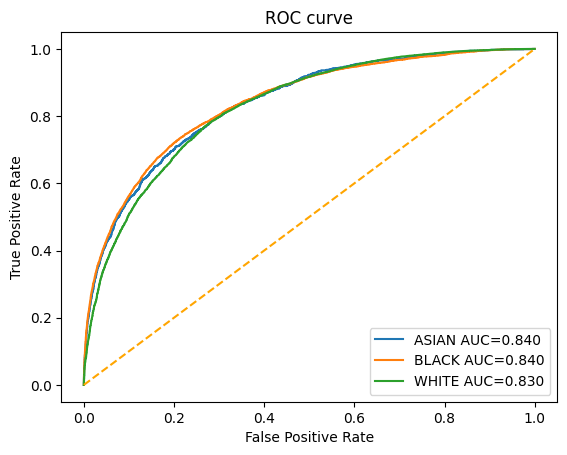

              precision    recall  f1-score   support

       ASIAN       0.45      0.10      0.17      1459
       BLACK       0.73      0.25      0.37      7148
       WHITE       0.87      0.98      0.92     44519

    accuracy                           0.86     53126
   macro avg       0.68      0.45      0.49     53126
weighted avg       0.84      0.86      0.83     53126



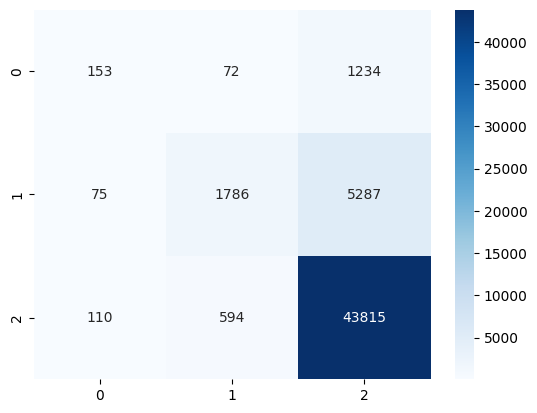

In [34]:
input_prediction_df = pd.read_csv(f'saved_models/test_All_race_20221204-110054.csv')
model_summary(y, test_batches, input_prediction_df, class_names)

   Study       AUC
0  ASIAN  0.847946
1  BLACK  0.827674
2  WHITE  0.816484
Classwise ROC AUC 

Class - ASIAN ROC-AUC- 0.85
Class - BLACK ROC-AUC- 0.83
Class - WHITE ROC-AUC- 0.82


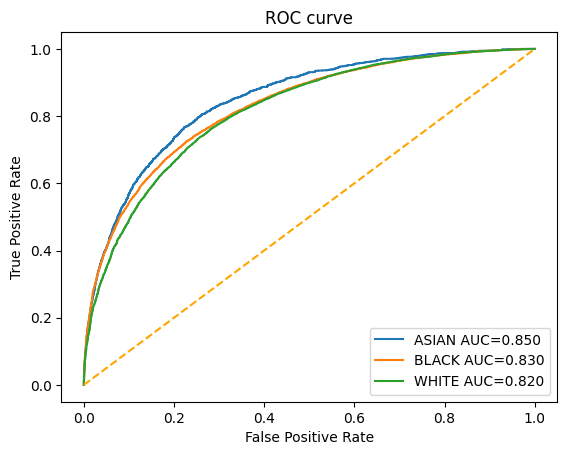

              precision    recall  f1-score   support

       ASIAN       0.10      0.71      0.17      1459
       BLACK       0.51      0.48      0.49      7148
       WHITE       0.93      0.75      0.83     44519

    accuracy                           0.72     53126
   macro avg       0.51      0.65      0.50     53126
weighted avg       0.85      0.72      0.77     53126



<AxesSubplot: >

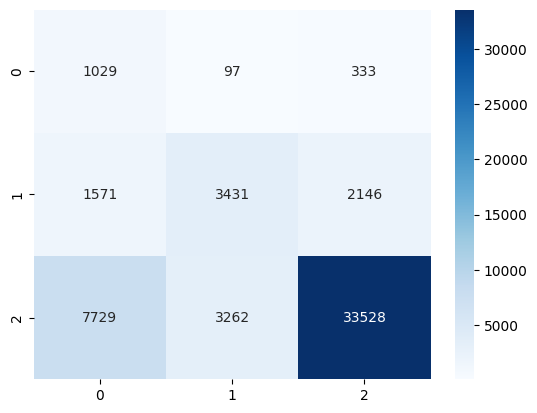

In [22]:
ground_truth = pd.Series(y)
assert len(y) == len(test_batches.classes)
get_AUC(input_prediction_df, ground_truth, class_names)
result = input_prediction_df.to_numpy()
labels = np.argmax(result, axis=1)
target_names = class_names #['Asian', 'Black', 'White']

print ('Classwise ROC AUC \n')
for p in list(set(labels)):
    fpr, tpr, thresholds = roc_curve(test_batches.classes, result[:,p], pos_label = p)
    auroc = round(auc(fpr, tpr), 2)
    print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))
    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(target_names[p], auroc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
plt.show()

print(classification_report(test_batches.classes, labels, target_names=target_names))
class_matrix = confusion_matrix(test_batches.classes, labels)

sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')

In [46]:
test_batches.classes.shape

(53126,)

In [47]:
results = pd.DataFrame({'y_test': test_batches.classes, 'y_pred': labels})
results.to_csv(f'results/{task}_pred_results_{var_date}.csv', index = False)
results

,y_test,y_pred
0,0,2
1,0,2
2,0,1
3,0,2
4,0,2
...,...,...
53121,2,2
53122,2,2
53123,2,2
53124,2,2


: 

# others

In [92]:
def evaluate_model(y_test, y_pred, printout = False):
    # test set
    #y_pred = model.predict(X_test) 
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = [] #roc_auc_score(y_test, y_pred)
    stats_test = [acc, precision, recall, f1, roc]
    if printout:
        print(f'Test: \nAccuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nAUC: {roc}\n')
    
    
    df_metrics = pd.DataFrame(data= {'Test': stats_test},  
                        index=['Accuracy', 'Precision', 'Recall', 'F1-score','AUC score'])
    return df_metrics

In [93]:
evaluate_model(y_test, y_pred)

,Test
Accuracy,0.81294
Precision,0.595789
Recall,0.578234
F1-score,0.577509
AUC score,[]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
 
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
 
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
 
    title:        the text to display at the top of the matrix
 
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
 
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
 
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
 
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
 
    """
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.show()

In [ ]:
def plot_roc(y_test, preds, title, label):
    fig = plt.figure(figsize=(8,6))

    for i in range(len(label)):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(label[i], roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
    plt.show()

   Study       AUC
0  ASIAN  0.815751
1  BLACK  0.831226
2  WHITE  0.819242
Classwise ROC AUC 

Class - Asian ROC-AUC- 0.82
Class - Black ROC-AUC- 0.83
Class - White ROC-AUC- 0.82


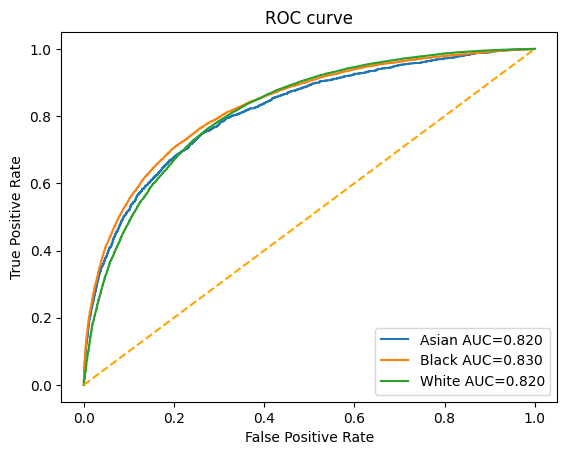

              precision    recall  f1-score   support

       Asian       0.59      0.05      0.10      2219
       Black       0.71      0.31      0.43     10456
       White       0.83      0.97      0.89     45027

    accuracy                           0.82     57702
   macro avg       0.71      0.45      0.47     57702
weighted avg       0.80      0.82      0.78     57702



<AxesSubplot: >

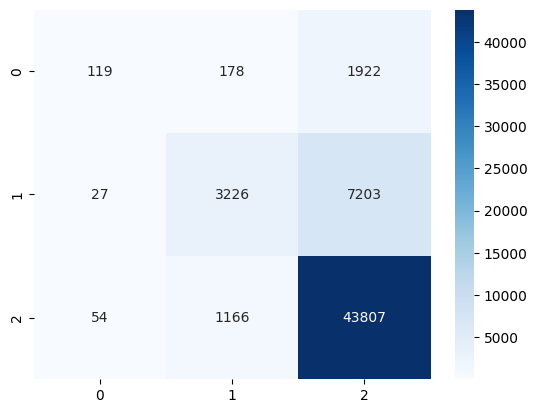

In [68]:
get_AUC(input_prediction_df, ground_truth)
result = input_prediction_df.to_numpy()
labels = np.argmax(result, axis=1)
target_names = ['Asian', 'Black', 'White']

print ('Classwise ROC AUC \n')
for p in list(set(labels)):
    fpr, tpr, thresholds = roc_curve(test_batches.classes, result[:,p], pos_label = p)
    auroc = round(auc(fpr, tpr), 2)
    print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))
    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='solid', label='{} AUC={:.3f}'.format(target_names[p], auroc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
plt.show()

print (classification_report(test_batches.classes, labels, target_names=target_names))
class_matrix = confusion_matrix(test_batches.classes, labels)

sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')